In [1]:
import math
import os
import copy
import time
import warnings
import torch

from tempfile import TemporaryDirectory
from typing import Tuple
from typing import List
from typing import Optional, Tuple
from typing import Optional, Any, Union, Callable

from torch import nn, Tensor
from torch.nn import functional as F
from torch.utils.data import dataset
from transformers import PreTrainedModel
from torch.nn.modules.linear import NonDynamicallyQuantizableLinear
from torch.nn.init import constant_, xavier_normal_, xavier_uniform_
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.nn.modules.container import ModuleList
from torch.nn.modules.dropout import Dropout
from torch.nn.modules.linear import Linear
from torch.nn.modules.normalization import LayerNorm
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from transformers import PretrainedConfig
from transformers import OpenAIGPTConfig, AutoTokenizer, OpenAIGPTLMHeadModel 

from datasets import load_dataset
import matplotlib.pyplot as plt
import common_utils

import torch.optim as optim

In [73]:
from transformers import AutoTokenizer, LlamaForCausalLM

model_name = "meta-llama/Llama-2-7b-hf"
model_name = "meta-llama/Meta-Llama-3-8B"

model = LlamaForCausalLM.from_pretrained(model_name, ignore_mismatched_sizes=True)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

KeyError: 'lm_head.weight'

In [3]:
import transformers
import torch

model_id = "meta-llama/Meta-Llama-3-8B"

pipeline = transformers.pipeline(
    "text-generation", model=model_id, model_kwargs={"torch_dtype": torch.bfloat16}, device_map="auto"
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

ValueError: Could not load model meta-llama/Meta-Llama-3-8B with any of the following classes: (<class 'transformers.models.auto.modeling_auto.AutoModelForCausalLM'>, <class 'transformers.models.llama.modeling_llama.LlamaForCausalLM'>).

In [71]:
model.model.layers[0]

LlamaDecoderLayer(
  (self_attn): LlamaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): LlamaRotaryEmbedding()
  )
  (mlp): LlamaMLP(
    (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
    (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
    (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
    (act_fn): SiLUActivation()
  )
  (input_layernorm): LlamaRMSNorm()
  (post_attention_layernorm): LlamaRMSNorm()
)

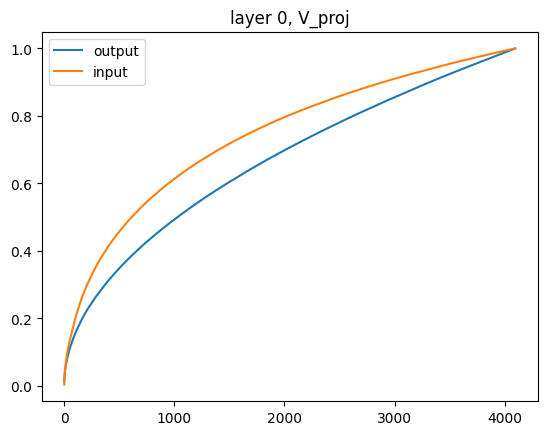

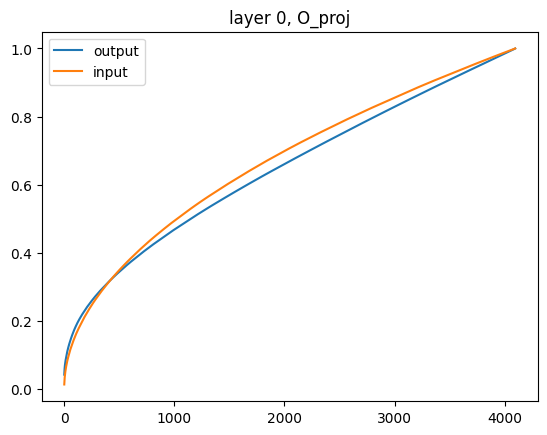

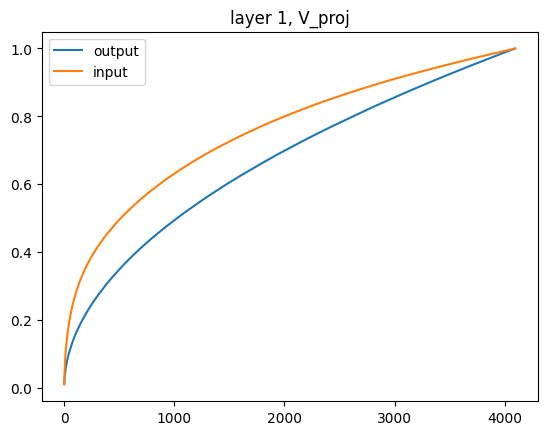

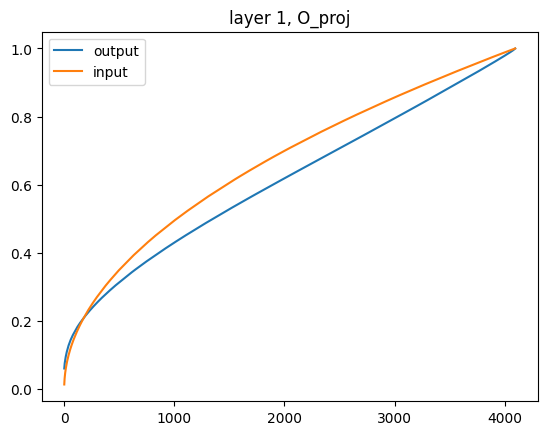

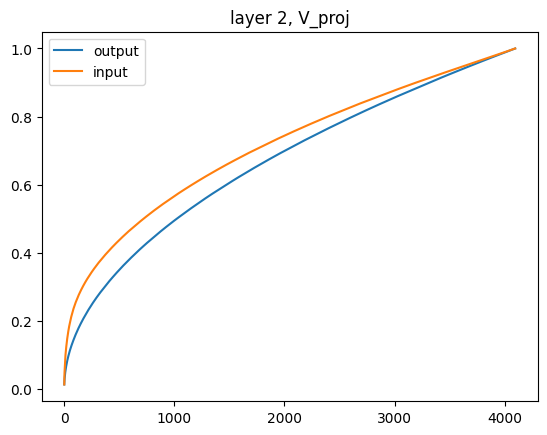

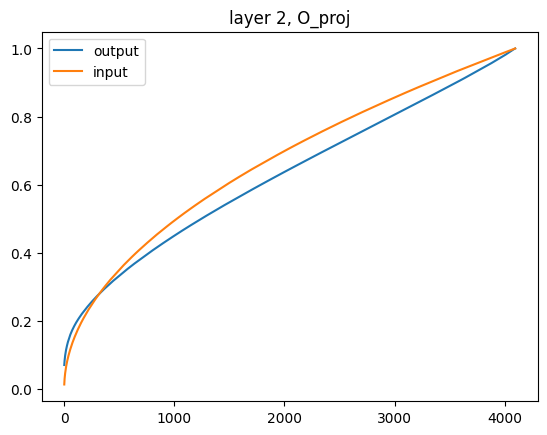

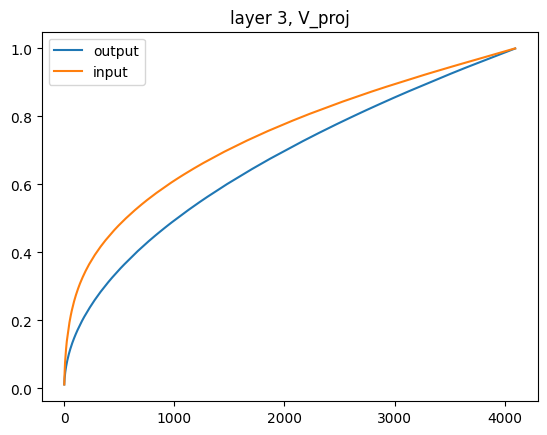

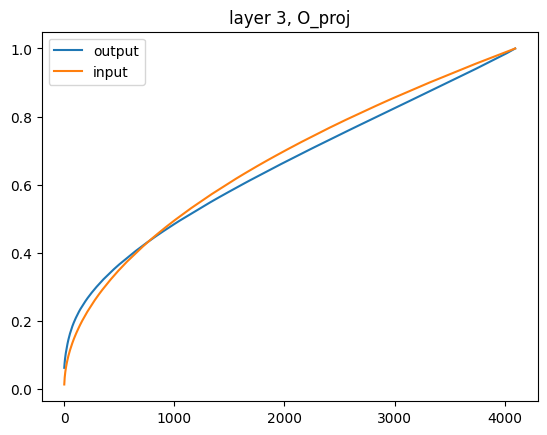

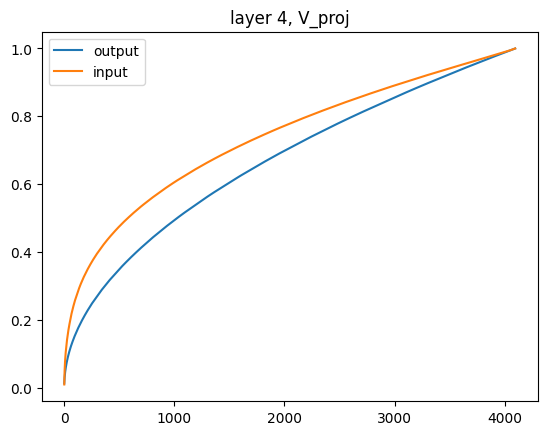

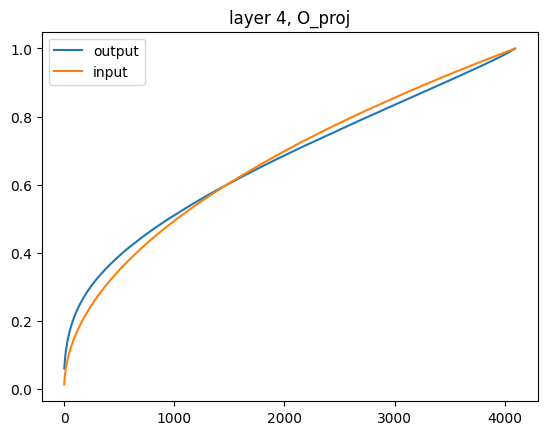

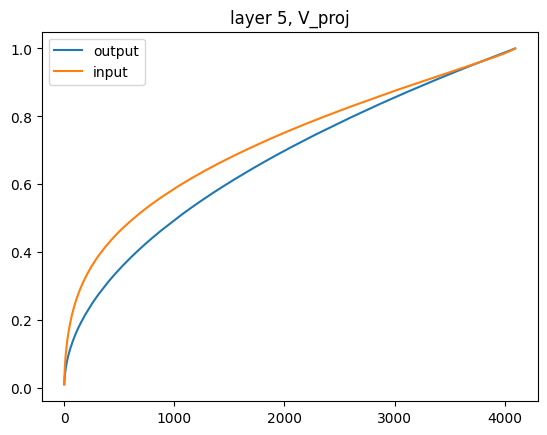

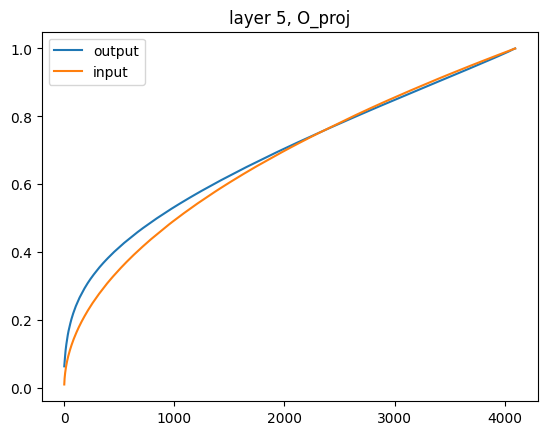

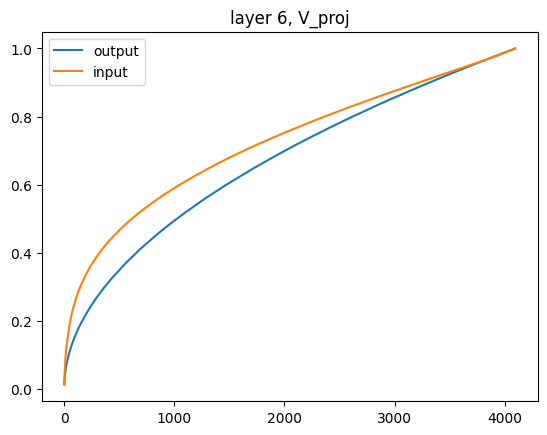

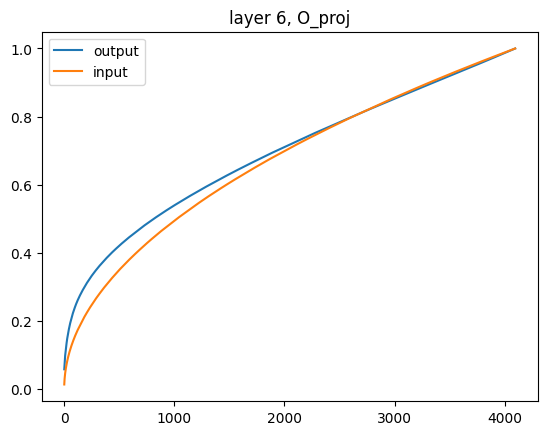

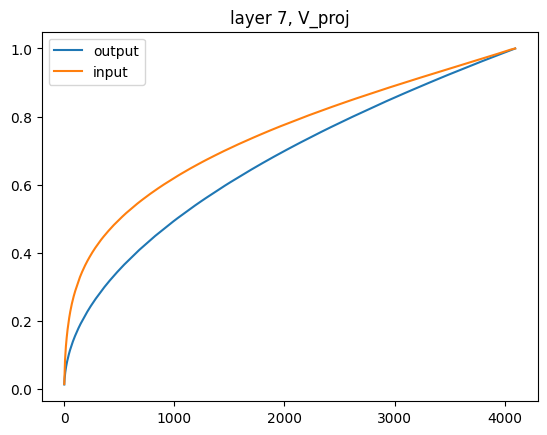

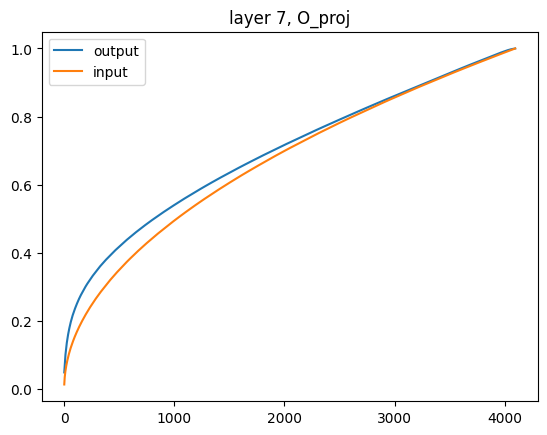

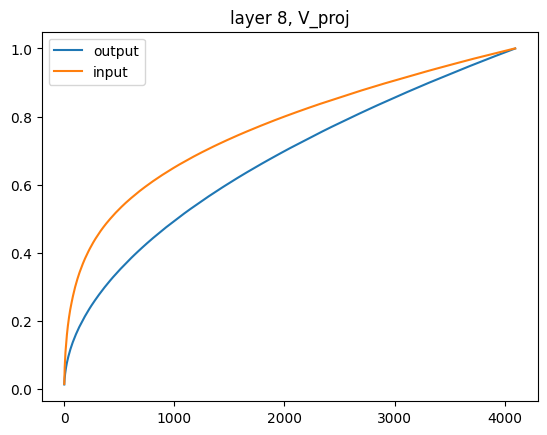

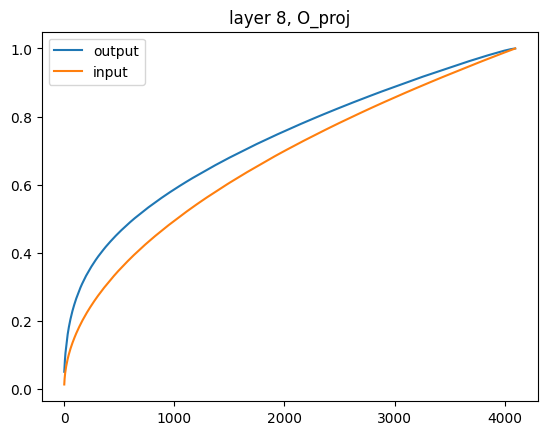

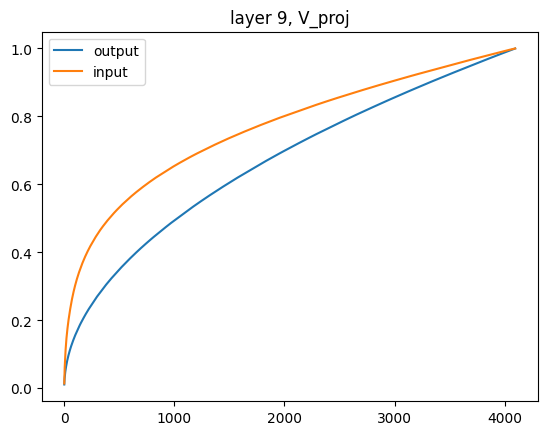

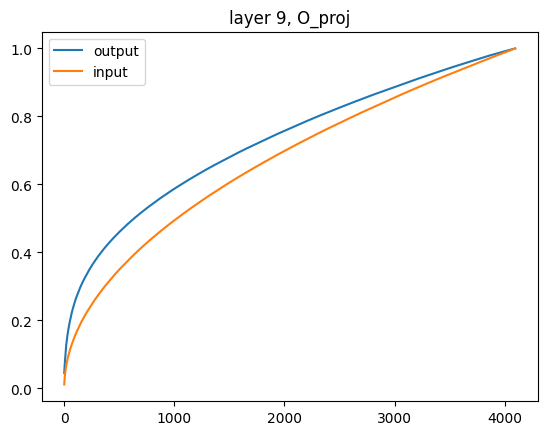

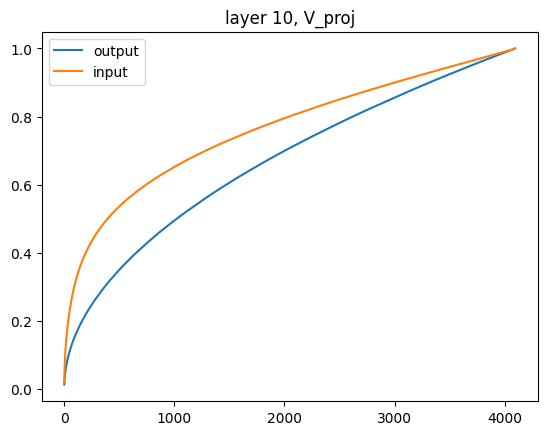

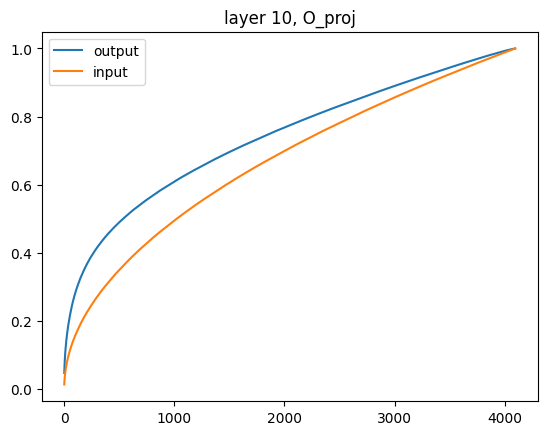

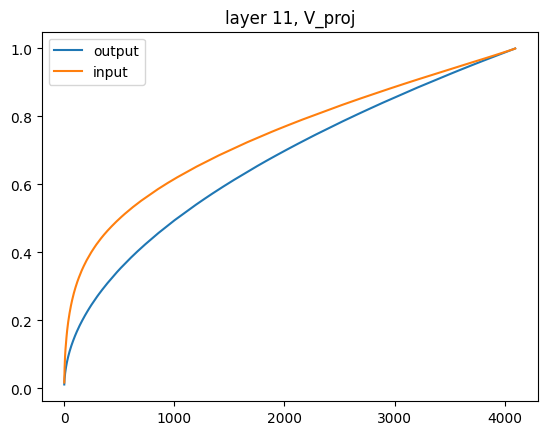

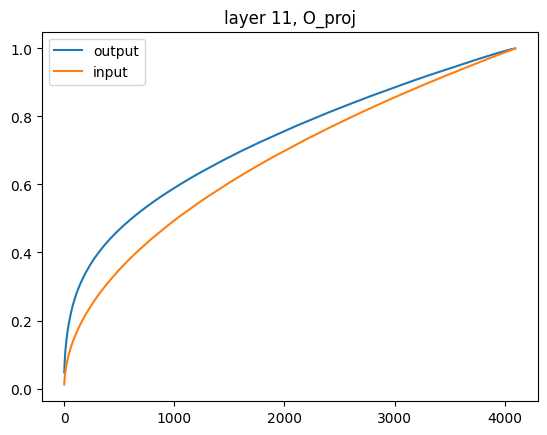

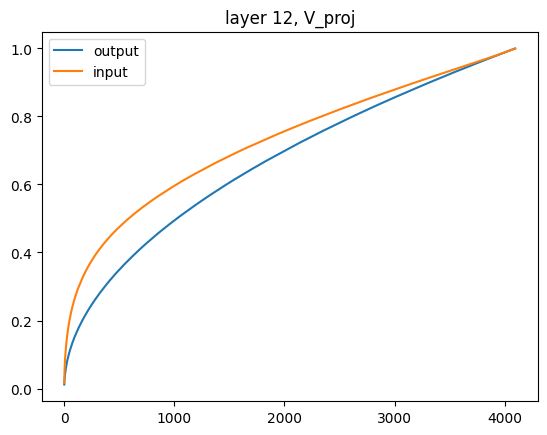

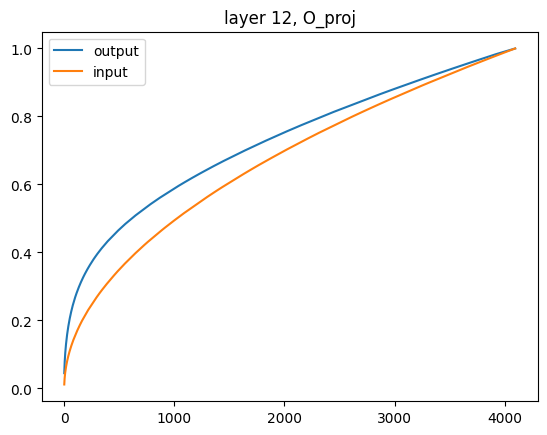

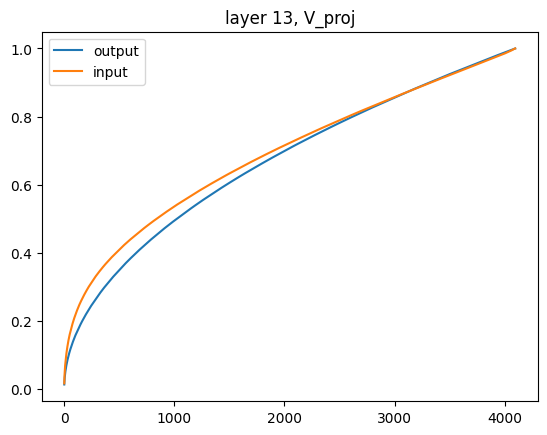

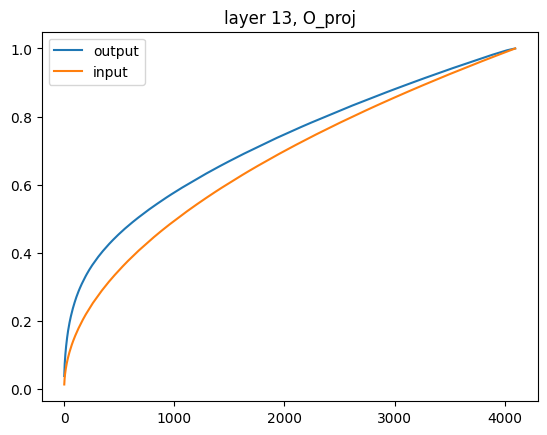

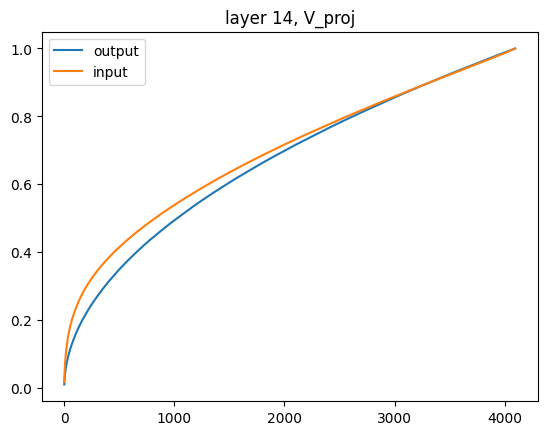

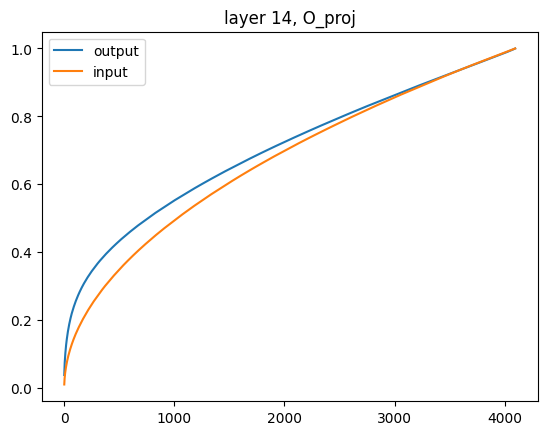

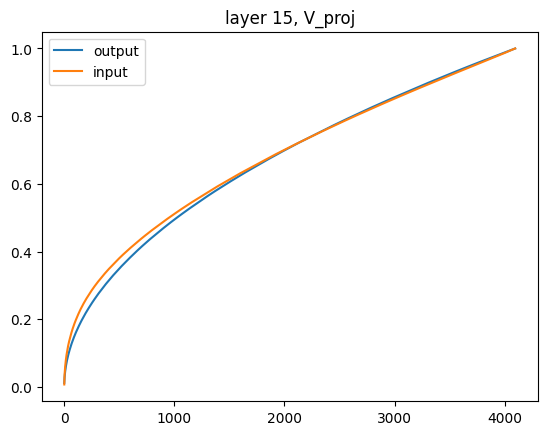

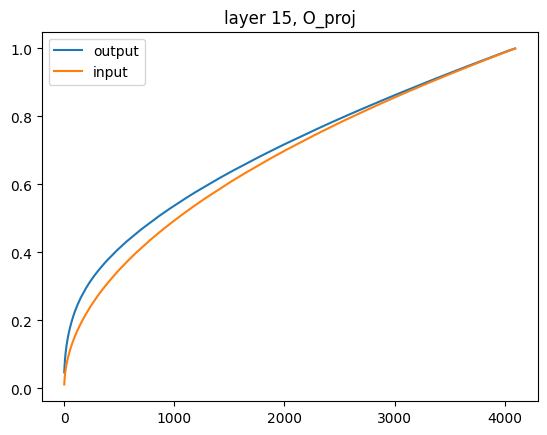

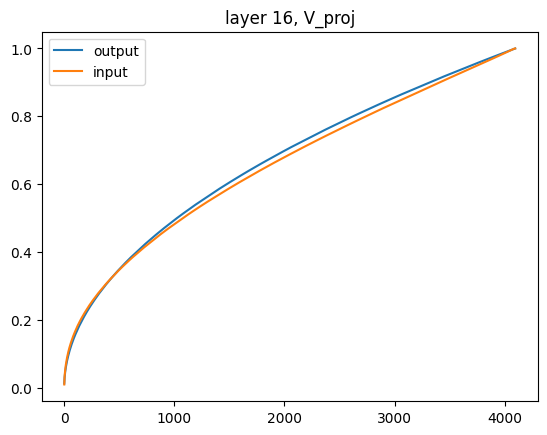

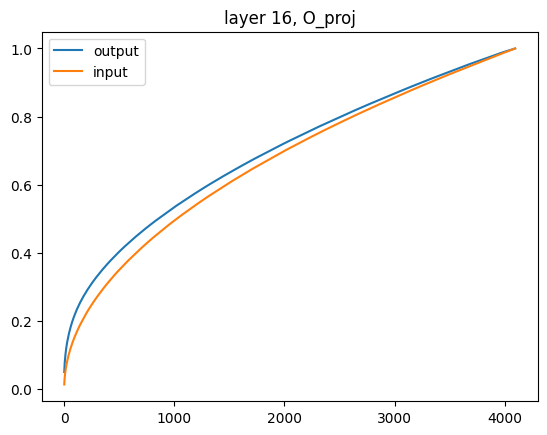

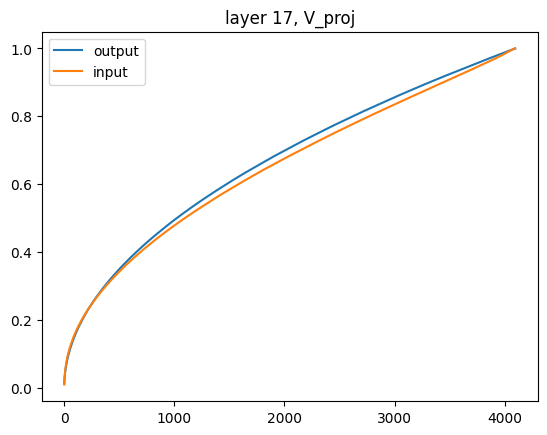

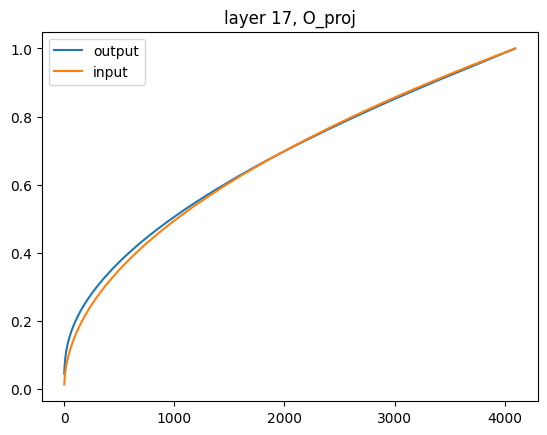

KeyboardInterrupt: 

In [72]:
def orth_analyze(M, U, title):
    col_coeffs = U.t() @ M
    row_coeffs = U.t() @ M.t()

    col_norms = M.norm(dim=0)
    row_norms = M.norm(dim=1)

    plt.plot((col_coeffs.pow(2).cumsum(dim=0).sqrt() / col_norms[None,:]).mean(dim=1).detach(), label="output")

    plt.plot((row_coeffs.pow(2).cumsum(dim=0).sqrt() / row_norms[None,:]).mean(dim=1).detach(), label="input")

    plt.legend()
    plt.title(title)
    plt.show()


for i in range(len(model.model.layers) - 1):
    next_v_proj = model.model.layers[i + 1].self_attn.v_proj
    next_o_proj = model.model.layers[i + 1].self_attn.o_proj
    down_proj = model.model.layers[i].mlp.down_proj

    U, S, V = torch.svd(down_proj.weight.detach())

    orth_analyze(next_v_proj.weight, U, f"layer {i}, V_proj")
    orth_analyze(next_o_proj.weight, U, f"layer {i}, O_proj")



In [33]:
print(proj_norm / orig_norm)

tensor([0.1594, 0.1681, 0.1459,  ..., 0.1296, 0.1786, 0.1663],
       grad_fn=<DivBackward0>)


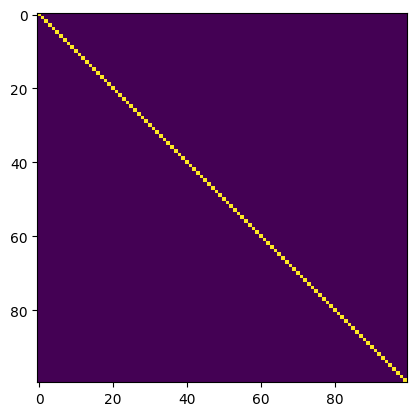

In [45]:
plt.imshow(U100.t() @ U100)

In [65]:
len(model.model.layers)

32